In [6]:
"""initialize db connection and llm"""
from langchain_community.utilities import SQLDatabase;

from dotenv import load_dotenv
import os

load_dotenv()

mysql_uri = 'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}'
db = SQLDatabase.from_uri(
    mysql_uri.format(
        username=os.getenv("MYSQL_USER"),
        password=os.getenv("MYSQL_PASS"),
        host=os.getenv("MYSQL_HOST"),
        port=os.getenv("MYSQL_PORT"),
        database=os.getenv("MYSQL_DBNAME")
    )
)

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

In [7]:
"""create agent"""
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

In [8]:
"""pull system prompt from community hub"""
from langchain import hub

prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()

/Users/jyothsnakullatira/PycharmProjects/play_with_llm_sql/.venv/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

In [9]:
"""initialize agent"""
from langgraph.prebuilt import create_react_agent

system_message = prompt_template.messages[0].format(dialect=db.dialect, top_k=10)
graph = create_react_agent(llm, tools, prompt=system_message)

In [10]:
"""ask a question / let's test the agent"""
question = "Which country's customers spent the most?"
latest_message = None
for step in graph.stream({"messages": [{"role": "user", "content": question}]}, stream_mode="updates"):
    if 'agent' in step:
        latest_message = step['agent']["messages"][-1]
latest_message.pretty_print()

================================== Ai Message ==================================

The country whose customers spent the most is the **USA**, with a total spending of **$523.06**. Here are the top 10 countries by customer spending:

1. **USA**: $523.06
2. **Canada**: $303.96
3. **France**: $195.10
4. **Brazil**: $193.38
5. **Germany**: $156.48
6. **United Kingdom**: $112.86
7. **Czech Republic**: $90.24
8. **Portugal**: $77.24
9. **India**: $75.26
10. **Chile**: $46.62


In [11]:
question = """For the following query, if it requires drawing a table, reply as follows:
            {"table": {"columns": ["column1", "column2", ...], "data": [[value1, value2, ...], [value1, value2, ...], ...]}}

            If the query requires creating a bar chart, reply as follows:
            {"bar": {"columns": ["A", "B", "C", ...], "data": [25, 24, 10, ...]}}

            If the query requires creating a line chart, reply as follows:
            {"line": {"columns": ["A", "B", "C", ...], "data": [25, 24, 10, ...]}}

            There can only be two types of chart, "bar" and "line".

            If it is just asking a question that requires neither, reply as follows:
            {"answer": "answer"}
            Example:
            {"answer": "The title with the highest rating is 'Gilead'"}"
            If you do not know the answer, reply as follows:
            {"answer": "I do not know."}

            Return all output as a string.

            All strings in "columns" list and data list, should be in double quotes,

            For example: {"columns": ["title", "ratings_count"], "data": [["Gilead", 361], ["Spider's Web", 5164]]}

            Lets think step by step.

            Below is the query.
            Query:
            """ + "For the best selling Artist, please tell me how many records were sold and where were the most records sold."
latest_message = None
for step in graph.stream({"messages": [{"role": "user", "content": question}]}, stream_mode="updates"):
    if 'agent' in step:
        latest_message = step['agent']["messages"][-1].content
print(latest_message)

{"table": {"columns": ["ArtistName", "TotalRecordsSold", "MostRecordsSoldCountry"], "data": [["Iron Maiden", 4, "USA"], ["U2", 4, "France"], ["Led Zeppelin", 4, "USA"], ["Iron Maiden", 3, "Canada"], ["Ozzy Osbourne", 3, "France"], ["Deep Purple", 2, "United Kingdom"], ["Os Paralamas Do Sucesso", 2, "France"], ["Deep Purple", 2, "Canada"], ["Iron Maiden", 2, "France"], ["Miles Davis", 2, "Canada"]]}}


In [12]:
def ask_question(graph, question):
    latest_message = None
    for step in graph.stream({"messages": [{"role": "user", "content": question}]}, stream_mode="updates"):
        if 'agent' in step:
            latest_message = step['agent']["messages"][-1]
    latest_message.pretty_print()

In [13]:
ask_question(graph, "Which artists have the longest albums? Please list each artist, their album and length")

================================== Ai Message ==================================

Here are the artists with the longest albums, along with the album titles and their lengths in milliseconds:

1. **Artist:** Lost  
   **Album:** Lost, Season 3  
   **Length:** 70,665,582 ms

2. **Artist:** Battlestar Galactica (Classic)  
   **Album:** Battlestar Galactica (Classic), Season 1  
   **Length:** 70,213,784 ms

3. **Artist:** Lost  
   **Album:** Lost, Season 1  
   **Length:** 64,854,936 ms

4. **Artist:** Lost  
   **Album:** Lost, Season 2  
   **Length:** 63,289,631 ms

5. **Artist:** Heroes  
   **Album:** Heroes, Season 1  
   **Length:** 59,780,268 ms

6. **Artist:** Battlestar Galactica  
   **Album:** Battlestar Galactica, Season 3  
   **Length:** 52,787,041 ms

7. **Artist:** Lost  
   **Album:** LOST, Season 4  
   **Length:** 39,468,433 ms

8. **Artist:** The Office  
   **Album:** The Office, Season 3  
   **Length:** 38,317,095 ms

9. **Artist:** The Office  
   **Album:** Th

In [14]:
ask_question(graph, " Which artists have more than 2 albums? Order by greatest album count.")

================================== Ai Message ==================================

Here are the artists who have more than 2 albums, ordered by the greatest album count:

1. Iron Maiden - 21 albums
2. Led Zeppelin - 14 albums
3. Deep Purple - 11 albums
4. Metallica - 10 albums
5. U2 - 10 albums
6. Ozzy Osbourne - 6 albums
7. Pearl Jam - 5 albums
8. Various Artists - 4 albums
9. Van Halen - 4 albums
10. Lost - 4 albums
11. Faith No More - 4 albums
12. Foo Fighters - 4 albums
13. Audioslave - 3 albums
14. Jamiroquai - 3 albums
15. Os Paralamas Do Sucesso - 3 albums
16. Guns N' Roses - 3 albums
17. Miles Davis - 3 albums
18. R.E.M. - 3 albums
19. Red Hot Chili Peppers - 3 albums
20. The Rolling Stones - 3 albums
21. Santana - 3 albums
22. Queen - 3 albums
23. Gilberto Gil - 3 albums
24. The Office - 3 albums
25. Eugene Ormandy - 3 albums
26. Berliner Philharmoniker & Herbert Von Karajan - 3 albums

If you need more specific information or a different format, let me know!


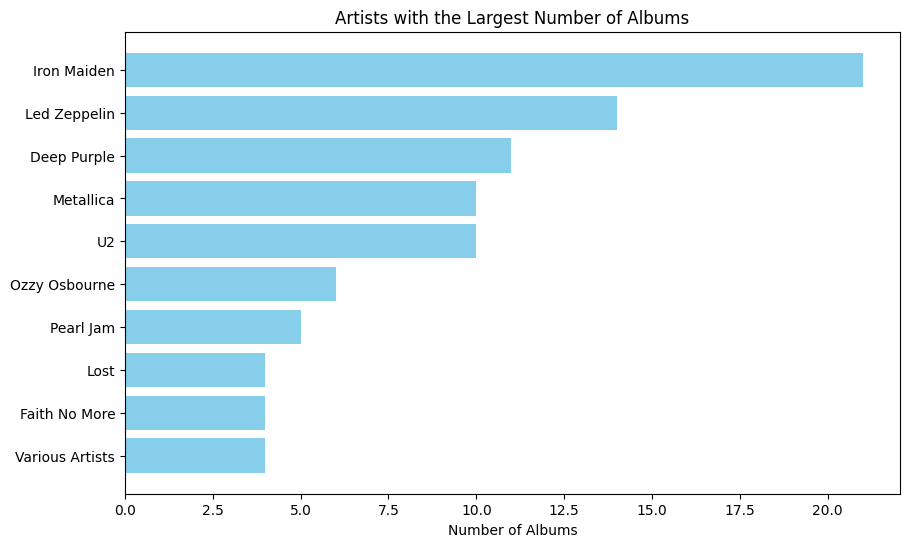

In [16]:
import matplotlib.pyplot as plt

# Data
artists = ['Iron Maiden', 'Led Zeppelin', 'Deep Purple', 'Metallica', 'U2',
           'Ozzy Osbourne', 'Pearl Jam', 'Lost', 'Faith No More', 'Various Artists']
album_counts = [21, 14, 11, 10, 10, 6, 5, 4, 4, 4]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.barh(artists, album_counts, color='skyblue')
plt.xlabel('Number of Albums')
plt.title('Artists with the Largest Number of Albums')
plt.gca().invert_yaxis()  # Invert y axis to have the artist with the most albums on top
plt.show()